# 🛠️ Telco Customer Churn - Feature Engineering

This notebook performs comprehensive feature engineering for the Telco Customer Churn dataset.

**Objectives**:
- Clean and preprocess data
- Create new meaningful features
- Encode categorical variables
- Scale numerical features
- Prepare data for machine learning

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)

print("🛠️ Feature Engineering Libraries Loaded!")

🛠️ Feature Engineering Libraries Loaded!


## 📥 Load Data

In [3]:
# Load the dataset
try:
    df = pd.read_csv('../data/customer_churn.csv')
    print(f"✅ Dataset loaded: {df.shape}")
except FileNotFoundError:
    print("❌ Dataset not found. Please run 01_data_exploration.ipynb first")
    df = None

if df is not None:
    print("\n📊 Dataset overview:")
    print(df.head())

✅ Dataset loaded: (7043, 21)

📊 Dataset overview:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        

## 🧹 Data Cleaning

In [4]:
# Data cleaning and preprocessing
print("🧹 DATA CLEANING")

# Check for data types and potential issues
print("\n📊 Current data types:")
print(df.dtypes)

# Check for any columns that should be numeric but are object type
print("\n🔍 Checking for numeric columns stored as objects:")
for col in df.columns:
    if df[col].dtype == 'object' and col not in ['customerID', 'Churn']:
        # Try to convert to numeric
        try:
            numeric_conversion = pd.to_numeric(df[col], errors='coerce')
            if numeric_conversion.notna().sum() > 0:
                print(f"  {col}: Can be converted to numeric")
                # Check for spaces or special characters
                unique_values = df[col].unique()
                print(f"    Unique values: {unique_values[:5]}")
        except:
            pass

🧹 DATA CLEANING

📊 Current data types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

🔍 Checking for numeric columns stored as objects:
  TotalCharges: Can be converted to numeric
    Unique values: ['29.85' '1889.5' '108.15' '1840.75' '151.65']


In [5]:
# Handle TotalCharges column (commonly has issues in this dataset)
if 'TotalCharges' in df.columns:
    print("🔧 Fixing TotalCharges column:")
    
    # Check current state
    print(f"Current dtype: {df['TotalCharges'].dtype}")
    print(f"Sample values: {df['TotalCharges'].head().tolist()}")
    
    # Convert to numeric, handling spaces and errors
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    # Check for missing values
    missing_count = df['TotalCharges'].isna().sum()
    print(f"Missing values after conversion: {missing_count}")
    
    if missing_count > 0:
        # Fill missing values with median or 0 for new customers
        # If tenure is 0, set TotalCharges to 0
        if 'tenure' in df.columns:
            df.loc[(df['tenure'] == 0) & (df['TotalCharges'].isna()), 'TotalCharges'] = 0
            # Fill remaining missing values with median
            df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
        else:
            df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
        
        print(f"✅ Missing values handled")
    
    print(f"Final dtype: {df['TotalCharges'].dtype}")
    print(f"Final stats: {df['TotalCharges'].describe()}")

🔧 Fixing TotalCharges column:
Current dtype: object
Sample values: ['29.85', '1889.5', '108.15', '1840.75', '151.65']
Missing values after conversion: 11
✅ Missing values handled
Final dtype: float64
Final stats: count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64


## 🎯 Target Variable Preparation

In [6]:
# Prepare target variable
print("🎯 TARGET VARIABLE PREPARATION")

if 'Churn' in df.columns:
    # Convert target to binary
    df['Churn_Binary'] = (df['Churn'] == 'Yes').astype(int)
    
    print(f"Target distribution:")
    print(df['Churn'].value_counts())
    print(f"\nBinary target distribution:")
    print(df['Churn_Binary'].value_counts())
    print(f"\nChurn rate: {df['Churn_Binary'].mean():.2%}")
else:
    print("❌ Churn column not found")

🎯 TARGET VARIABLE PREPARATION
Target distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Binary target distribution:
Churn_Binary
0    5174
1    1869
Name: count, dtype: int64

Churn rate: 26.54%


## 🆕 Feature Creation

In [7]:
# Create new features
print("🆕 CREATING NEW FEATURES")

# 1. Monthly charges per service ratio
if 'MonthlyCharges' in df.columns and 'tenure' in df.columns:
    # Average monthly charges (handling division by zero)
    df['AvgMonthlyCharges'] = df['MonthlyCharges']
    
    # Total charges per tenure month
    if 'TotalCharges' in df.columns:
        df['ChargesPerTenure'] = df['TotalCharges'] / (df['tenure'] + 1)  # +1 to avoid division by zero
    
    print("✅ Charges-based features created")

# 2. Service count features
service_cols = []
for col in df.columns:
    if any(service in col.lower() for service in ['phone', 'internet', 'online', 'backup', 'protection', 'support', 'streaming']):
        if df[col].dtype == 'object' and 'Yes' in df[col].unique():
            service_cols.append(col)

if service_cols:
    print(f"\nService columns identified: {service_cols}")
    
    # Count total services
    df['TotalServices'] = 0
    for col in service_cols:
        df['TotalServices'] += (df[col] == 'Yes').astype(int)
    
    # Service penetration rate
    df['ServicePenetration'] = df['TotalServices'] / len(service_cols)
    
    print(f"✅ Service count features created")
    print(f"Total services stats: {df['TotalServices'].describe()}")

# 3. Customer lifetime value features
if 'MonthlyCharges' in df.columns and 'tenure' in df.columns:
    # Customer lifetime value estimation
    df['EstimatedCLV'] = df['MonthlyCharges'] * df['tenure']
    
    # Monthly charges to tenure ratio
    df['ChargesTenureRatio'] = df['MonthlyCharges'] / (df['tenure'] + 1)
    
    print("✅ Customer value features created")

# 4. Contract and payment features
if 'Contract' in df.columns:
    # Contract length mapping
    contract_mapping = {
        'Month-to-month': 1,
        'One year': 12,
        'Two year': 24
    }
    df['ContractLength'] = df['Contract'].map(contract_mapping)
    
    # Long-term contract indicator
    df['LongTermContract'] = (df['ContractLength'] >= 12).astype(int)
    
    print("✅ Contract features created")

# 5. Demographic features
if 'SeniorCitizen' in df.columns and 'tenure' in df.columns:
    # Senior citizen with long tenure
    df['SeniorLongTenure'] = ((df['SeniorCitizen'] == 1) & (df['tenure'] > 12)).astype(int)
    
    print("✅ Demographic features created")

print(f"\n📊 Total features after creation: {df.shape[1]}")

🆕 CREATING NEW FEATURES
✅ Charges-based features created

Service columns identified: ['PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
✅ Service count features created
Total services stats: count    7043.000000
mean        2.941076
std         1.843899
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max         7.000000
Name: TotalServices, dtype: float64
✅ Customer value features created
✅ Contract features created
✅ Demographic features created

📊 Total features after creation: 31


## 🏷️ Categorical Encoding

In [8]:
# Categorical variable encoding
print("🏷️ CATEGORICAL ENCODING")

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target and ID columns
exclude_cols = ['customerID', 'Churn']
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

print(f"Categorical columns to encode: {categorical_cols}")

# Create a copy for encoding
df_encoded = df.copy()

# Binary encoding for Yes/No columns
binary_cols = []
for col in categorical_cols:
    unique_values = df[col].unique()
    if len(unique_values) == 2 and set(unique_values) <= {'Yes', 'No'}:
        binary_cols.append(col)
        df_encoded[col] = (df[col] == 'Yes').astype(int)

print(f"Binary encoded columns: {binary_cols}")

# One-hot encoding for multi-category columns
remaining_categorical = [col for col in categorical_cols if col not in binary_cols]

if remaining_categorical:
    print(f"One-hot encoding columns: {remaining_categorical}")
    
    for col in remaining_categorical:
        # Create dummy variables
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        # Drop original column
        df_encoded.drop(col, axis=1, inplace=True)
    
    print("✅ One-hot encoding completed")

print(f"\n📊 Features after encoding: {df_encoded.shape[1]}")
print(f"New columns: {[col for col in df_encoded.columns if col not in df.columns]}")

🏷️ CATEGORICAL ENCODING
Categorical columns to encode: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Binary encoded columns: ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
One-hot encoding columns: ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
✅ One-hot encoding completed

📊 Features after encoding: 42
New columns: ['gender_Male', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'T

## 📏 Feature Scaling

In [9]:
# Feature scaling
print("📏 FEATURE SCALING")

# Identify numerical columns for scaling
exclude_from_scaling = ['customerID', 'Churn', 'Churn_Binary'] + \
                      [col for col in df_encoded.columns if col.endswith('_Yes') or col.endswith('_No')] + \
                      binary_cols

numerical_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
cols_to_scale = [col for col in numerical_cols if col not in exclude_from_scaling]

print(f"Columns to scale: {cols_to_scale}")

if cols_to_scale:
    # Create scaled version
    df_scaled = df_encoded.copy()
    
    # StandardScaler for features with normal distribution
    scaler = StandardScaler()
    df_scaled[cols_to_scale] = scaler.fit_transform(df_encoded[cols_to_scale])
    
    print("✅ Standard scaling completed")
    
    # Show scaling effect
    print("\n📊 Scaling effect:")
    scaling_comparison = pd.DataFrame({
        'Original_Mean': df_encoded[cols_to_scale].mean(),
        'Original_Std': df_encoded[cols_to_scale].std(),
        'Scaled_Mean': df_scaled[cols_to_scale].mean(),
        'Scaled_Std': df_scaled[cols_to_scale].std()
    })
    print(scaling_comparison.head())
else:
    df_scaled = df_encoded.copy()
    print("No columns need scaling")

📏 FEATURE SCALING
Columns to scale: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharges', 'ChargesPerTenure', 'TotalServices', 'ServicePenetration', 'EstimatedCLV', 'ChargesTenureRatio', 'ContractLength', 'LongTermContract', 'SeniorLongTenure']
✅ Standard scaling completed

📊 Scaling effect:
                   Original_Mean  Original_Std   Scaled_Mean  Scaled_Std
SeniorCitizen           0.162147      0.368612 -4.842546e-17    1.000071
tenure                 32.371149     24.559481 -2.421273e-17    1.000071
MonthlyCharges         64.761692     30.090047 -6.406285e-17    1.000071
TotalCharges         2279.734304   2266.794470 -3.783239e-17    1.000071
AvgMonthlyCharges      64.761692     30.090047 -6.406285e-17    1.000071


## 🎯 Final Feature Selection

In [10]:
# Final feature selection and preparation
print("🎯 FINAL FEATURE SELECTION")

# Remove unnecessary columns
columns_to_remove = ['customerID', 'Churn']  # Keep Churn_Binary as target
feature_columns = [col for col in df_scaled.columns if col not in columns_to_remove]

# Prepare final dataset
df_final = df_scaled[feature_columns].copy()

print(f"Final dataset shape: {df_final.shape}")
print(f"Features: {len(feature_columns) - 1}")  # -1 for target column
print(f"Target column: Churn_Binary")

# Show final feature list
features = [col for col in feature_columns if col != 'Churn_Binary']
print(f"\n📋 Final features ({len(features)}):")
for i, feature in enumerate(features, 1):
    print(f"{i:2d}. {feature}")

🎯 FINAL FEATURE SELECTION
Final dataset shape: (7043, 40)
Features: 39
Target column: Churn_Binary

📋 Final features (39):
 1. SeniorCitizen
 2. Partner
 3. Dependents
 4. tenure
 5. PhoneService
 6. PaperlessBilling
 7. MonthlyCharges
 8. TotalCharges
 9. AvgMonthlyCharges
10. ChargesPerTenure
11. TotalServices
12. ServicePenetration
13. EstimatedCLV
14. ChargesTenureRatio
15. ContractLength
16. LongTermContract
17. SeniorLongTenure
18. gender_Male
19. MultipleLines_No phone service
20. MultipleLines_Yes
21. InternetService_Fiber optic
22. InternetService_No
23. OnlineSecurity_No internet service
24. OnlineSecurity_Yes
25. OnlineBackup_No internet service
26. OnlineBackup_Yes
27. DeviceProtection_No internet service
28. DeviceProtection_Yes
29. TechSupport_No internet service
30. TechSupport_Yes
31. StreamingTV_No internet service
32. StreamingTV_Yes
33. StreamingMovies_No internet service
34. StreamingMovies_Yes
35. Contract_One year
36. Contract_Two year
37. PaymentMethod_Credit car

## 📊 Feature Correlation Analysis

📊 FEATURE CORRELATION WITH TARGET
Top 15 features correlated with churn:
ChargesTenureRatio                      0.411756
LongTermContract                       -0.405103
ContractLength                         -0.394453
tenure                                 -0.352229
InternetService_Fiber optic             0.308020
Contract_Two year                      -0.302253
PaymentMethod_Electronic check          0.301919
DeviceProtection_No internet service   -0.227890
OnlineBackup_No internet service       -0.227890
OnlineSecurity_No internet service     -0.227890
InternetService_No                     -0.227890
StreamingTV_No internet service        -0.227890
StreamingMovies_No internet service    -0.227890
TechSupport_No internet service        -0.227890
EstimatedCLV                           -0.198514
Name: Churn_Binary, dtype: float64


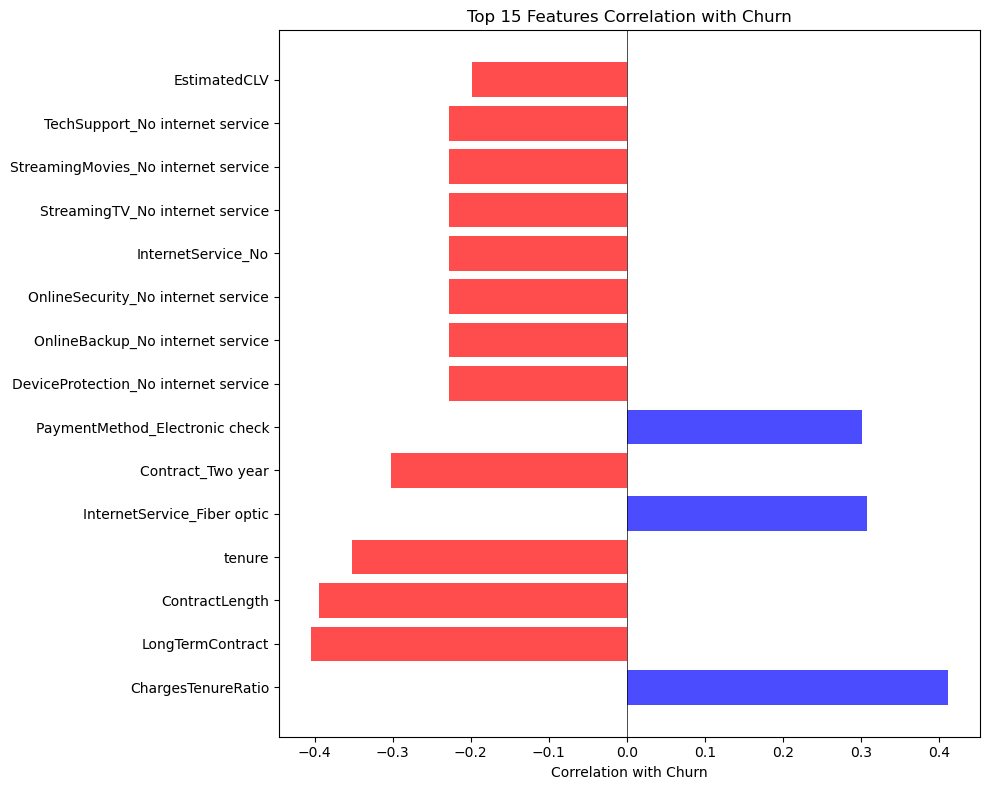

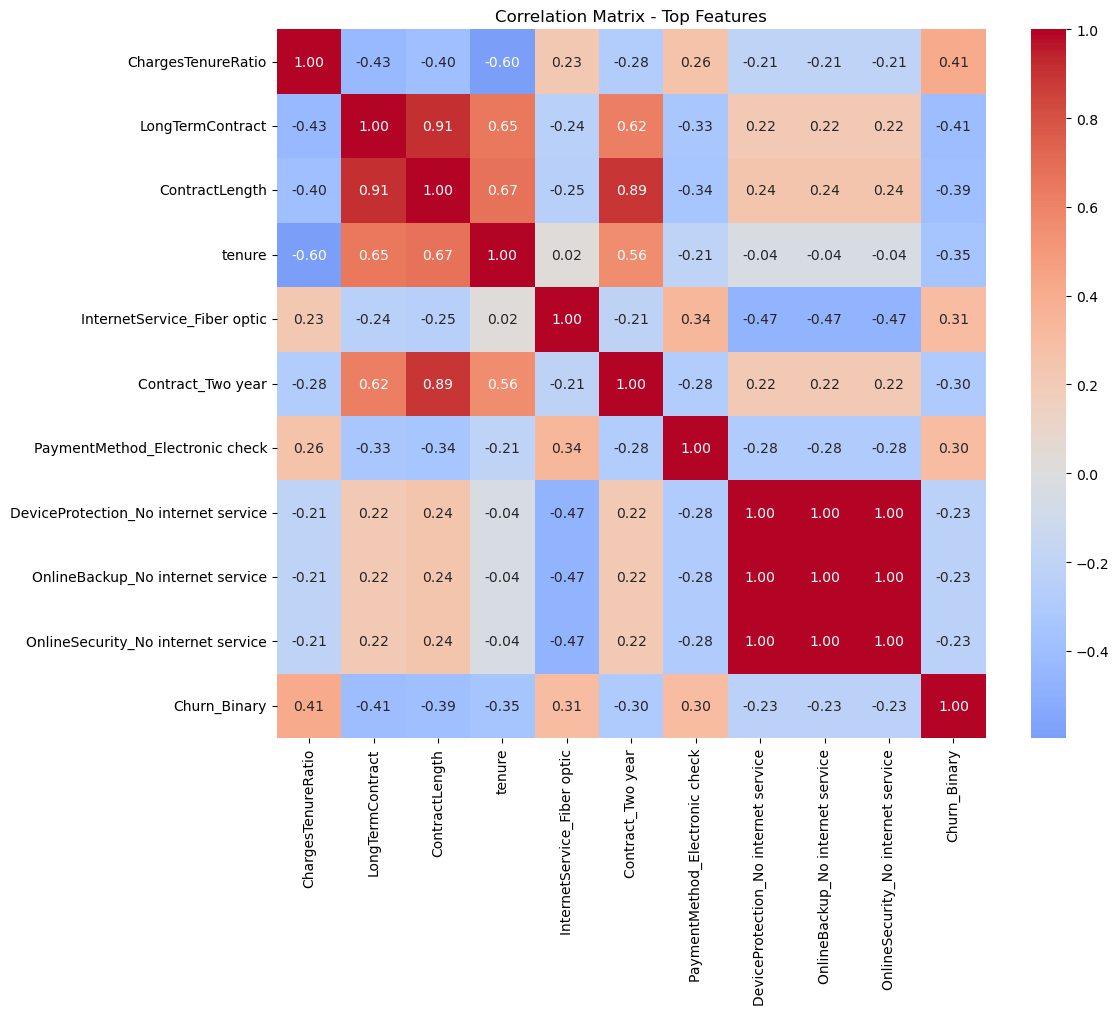

In [11]:
# Correlation analysis with target
print("📊 FEATURE CORRELATION WITH TARGET")

if 'Churn_Binary' in df_final.columns:
    # Calculate correlation with target
    target_correlation = df_final.corr()['Churn_Binary'].drop('Churn_Binary')
    target_correlation = target_correlation.sort_values(key=abs, ascending=False)
    
    print("Top 15 features correlated with churn:")
    print(target_correlation.head(15))
    
    # Visualize top correlations
    plt.figure(figsize=(10, 8))
    top_correlations = target_correlation.head(15)
    colors = ['red' if x < 0 else 'blue' for x in top_correlations.values]
    
    plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_correlations)), top_correlations.index)
    plt.xlabel('Correlation with Churn')
    plt.title('Top 15 Features Correlation with Churn')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # Feature correlation matrix (top features)
    top_features = target_correlation.head(10).index.tolist() + ['Churn_Binary']
    correlation_matrix = df_final[top_features].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f')
    plt.title('Correlation Matrix - Top Features')
    plt.tight_layout()
    plt.show()

## ✂️ Remove Highly Correlated Features

In [12]:
# Remove highly correlated features to reduce multicollinearity
print("✂️ REMOVING HIGHLY CORRELATED FEATURES")

# Calculate correlation matrix (excluding target)
feature_cols = [col for col in df_final.columns if col != 'Churn_Binary']
feature_corr_matrix = df_final[feature_cols].corr()

# Find highly correlated pairs
high_corr_pairs = []
threshold = 0.8  # Correlation threshold

for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        if abs(feature_corr_matrix.iloc[i, j]) > threshold:
            col1 = feature_corr_matrix.columns[i]
            col2 = feature_corr_matrix.columns[j]
            corr_value = feature_corr_matrix.iloc[i, j]
            high_corr_pairs.append((col1, col2, corr_value))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} highly correlated pairs (threshold: {threshold}):")
    for col1, col2, corr in high_corr_pairs:
        print(f"  {col1} <-> {col2}: {corr:.3f}")
    
    # Remove features with lower correlation to target
    features_to_remove = set()
    for col1, col2, corr in high_corr_pairs:
        # Keep the feature with higher absolute correlation to target
        corr1 = abs(target_correlation.get(col1, 0))
        corr2 = abs(target_correlation.get(col2, 0))
        
        if corr1 < corr2:
            features_to_remove.add(col1)
        else:
            features_to_remove.add(col2)
    
    print(f"\nRemoving {len(features_to_remove)} features: {list(features_to_remove)}")
    
    # Create final dataset without highly correlated features
    final_features = [col for col in df_final.columns if col not in features_to_remove]
    df_final = df_final[final_features]
    
    print(f"Final dataset shape after correlation removal: {df_final.shape}")
else:
    print(f"No highly correlated features found (threshold: {threshold})")

print(f"\n📊 Final dataset ready for modeling: {df_final.shape}")

✂️ REMOVING HIGHLY CORRELATED FEATURES
Found 34 highly correlated pairs (threshold: 0.8):
  SeniorCitizen <-> SeniorLongTenure: 0.826
  tenure <-> TotalCharges: 0.826
  tenure <-> EstimatedCLV: 0.827
  PhoneService <-> MultipleLines_No phone service: -1.000
  MonthlyCharges <-> AvgMonthlyCharges: 1.000
  MonthlyCharges <-> ChargesPerTenure: 0.956
  TotalCharges <-> EstimatedCLV: 1.000
  AvgMonthlyCharges <-> ChargesPerTenure: 0.956
  ChargesPerTenure <-> TotalServices: 0.808
  ChargesPerTenure <-> ServicePenetration: 0.808
  TotalServices <-> ServicePenetration: 1.000
  ContractLength <-> LongTermContract: 0.907
  ContractLength <-> Contract_Two year: 0.894
  InternetService_No <-> OnlineSecurity_No internet service: 1.000
  InternetService_No <-> OnlineBackup_No internet service: 1.000
  InternetService_No <-> DeviceProtection_No internet service: 1.000
  InternetService_No <-> TechSupport_No internet service: 1.000
  InternetService_No <-> StreamingTV_No internet service: 1.000
  Int

## 💾 Save Processed Data

In [13]:
# Save the final processed dataset
print("💾 SAVING PROCESSED DATA")

# Save full processed dataset
df_final.to_csv('../data/telco_processed_features.csv', index=False)
print("✅ Full processed dataset saved as '../data/telco_processed_features.csv'")

# Save feature names for future use
feature_names = [col for col in df_final.columns if col != 'Churn_Binary']
pd.DataFrame({'feature_names': feature_names}).to_csv('../data/feature_names.csv', index=False)
print("✅ Feature names saved as '../data/feature_names.csv'")

# Save preprocessing summary
preprocessing_summary = {
    'original_shape': df.shape,
    'final_shape': df_final.shape,
    'features_created': df_final.shape[1] - df.shape[1],
    'churn_rate': df_final['Churn_Binary'].mean(),
    'total_features': len(feature_names),
    'categorical_encoded': len(binary_cols) + len(remaining_categorical),
    'features_scaled': len(cols_to_scale) if 'cols_to_scale' in locals() else 0
}

summary_df = pd.DataFrame([preprocessing_summary])
summary_df.to_csv('../data/preprocessing_summary.csv', index=False)
print("✅ Preprocessing summary saved as '../data/preprocessing_summary.csv'")

print("\n📋 FEATURE ENGINEERING SUMMARY:")
print(f"✅ Original dataset: {df.shape}")
print(f"✅ Final dataset: {df_final.shape}")
print(f"✅ Features for modeling: {len(feature_names)}")
print(f"✅ Churn rate: {df_final['Churn_Binary'].mean():.2%}")
print(f"✅ Data ready for machine learning!")

print("\n🚀 Next steps:")
print("1. Run notebook: 03_exploratory_data_analysis.ipynb")
print("2. Run notebook: 04_machine_learning_models.ipynb")
print("3. Run notebook: 05_model_evaluation.ipynb")

💾 SAVING PROCESSED DATA
✅ Full processed dataset saved as '../data/telco_processed_features.csv'
✅ Feature names saved as '../data/feature_names.csv'
✅ Preprocessing summary saved as '../data/preprocessing_summary.csv'

📋 FEATURE ENGINEERING SUMMARY:
✅ Original dataset: (7043, 31)
✅ Final dataset: (7043, 25)
✅ Features for modeling: 24
✅ Churn rate: 26.54%
✅ Data ready for machine learning!

🚀 Next steps:
1. Run notebook: 03_exploratory_data_analysis.ipynb
2. Run notebook: 04_machine_learning_models.ipynb
3. Run notebook: 05_model_evaluation.ipynb
